# Redes Neuronales 2020
## Trabajo Práctico 2
### Integrate-and-Fire

Se considera el modelo **Integrate-and-Fire** para la evolución temporal del potencial de membrana $ V_m (t) $ al tiempo $ t $ entre el interior y el exterior de una neurona genérica:

$$ \tau_m {{\partial V_m(t) }\over{ \partial t }} = E_L - V_m(t) + R_m I_e(t), $$

donde $ E_L $ es el potencial en reposo, $ I_e(t) $ es una corriente eléctrica externa (cuyo valor positivo corresponde a una corriente entrante) que se inyecta (input), $ R_m $ es la resistencia y $ \tau_m $ es el tiempo característico de la membrana $ \tau_m = r_m c_m $ (donde $ r_m $ y $ c_m $ son respectivamente la resistencia y la capacitancia de la membrana por unidad de área). Esta ecuación se puede reescribir cómo:

$$ {{\partial V_m(t) }\over{ \partial t }} = {1 \over \tau_m} ( E_L - V_m(t) + R_m I_e(t) ), $$

Consideramos:

- **mV** = miliVoltio (1/1000) de un voltio
- $ M\Omega $ = megaohms *(ohm is the resistance between two points of an electrical conductor transmitting a current of one ampere when the potential difference is one volt)*

### Imports

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from autoclass import autoargs
from scipy import integrate

# cool plots
sns.set_style("darkgrid")

# ensure reproducibility
np.random.seed(23)

### Resolución analítica

Vamos a resolver la ecuación anterior (sin considerar el umbral de disparo), para el caso de una corriente externa $ I_e $ constante y definiendo $ V_m $ como: 

$$ I_e (t) = I_e, \qquad V_m (t = 0) = V_0 $$

Luego, vamos a graficar la solución para $ 0ms \leq t \leq 200ms $ con los siguientes valores para los parámetros:

$$ V_m(t = 0) = E_L = -65mV, \qquad R = 10 M \Omega, \qquad V_{th} = -50 mV, \qquad \tau_m = 10ms $$

Para poder resolver analíticamente la ecuación, vamos a considerar una aproximación utilizando los valores que previamente conocemos de $ V_m(t) $. Sabemos el valor inicial, ya que contamos con que $ E_L = -65 mV $. Luego, podemos utilizar la siguiente fórmula para conocer los valores siguientes:

$$ V_m(t + \Delta t) = V_m(t) + {\Delta t \over \tau_m} (E_L + V_m(t) + R_m I_e(t)) $$

Donde $ \Delta t $ representa la diferencia temporal desde el valor conocido, mientras más chica sea esta diferencia, más acertada va a ser nuestra predicción. En nuestro caso, con los parámetros dados, vamos a definir $ \Delta t = 1 $, ya que sólo vamos a aproximar el crecimiento de nuestra neurona y no vamos a considerar el umbral de disparo ($ V_th $). 

Llegamos a la siguiente resolución:

$$ V_m (t + 1) = V_m(t) + { 1 \over \tau_m } ( - 65 + V_m(t) + 10 I_e )  $$

Ahora, vamos a graficar estos valores para el intervalo temporal pedido:

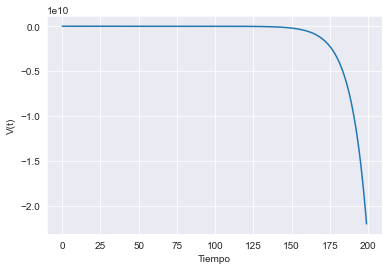

In [22]:
# definimos el intervalo de tiempo
dt = 1 # ms
T = np.arange(0, 200, dt)

# definimos los parámetros dados
tau = 10 # ms
E = -65 # mV
R = 10 # MOhms
I = 1 # mV

# inicializamos los valores de V
# utilizando el valor inicial E
V = np.zeros_like(T) + E

# ahora aproximamos los valores de V
# sin considerar el umbral de disparo
for i, t in enumerate(T):
    V[i] = V[i - 1] + ((dt / tau) * (E + V[i - 1] + (R*I)))

# graficamos los resultados
plt.plot(T, V)
plt.ylabel('V(t)')
plt.xlabel('Tiempo')
plt.show()

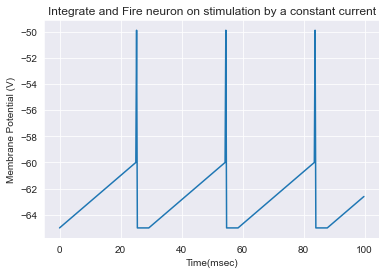

In [28]:
T       = 100                  # Simulation Time (msec)
dt      = 0.25               # Time step (msec)
time    = np.arange(0, T, dt) 
tau   = 1 
t_rest  = 0 
  
 ## LIF properties
Vop      = np.zeros(len(time))-65    # potential (V) trace over time [ keeping the base voltage to be set at -65mV ] 
R      = 1                   # resistance (kOhm)
C     = 10                  # capacitance (uF)
tau   = R*C             # time constant (msec)
tau_ref = 4                   # refractory period (msec)
Vth     = -60                   # spike threshold (V)
V_spike = 70                 # spike delta (V)

 ## Stimulus
I       = 2                # input current (A)

 ## iterate over each time step
for i, t in enumerate(time):
    if t > t_rest:
        Vop[i] = Vop[i-1] + (I*R) / tau * dt #Integration Process 
    if Vop[i] >= Vth:                         # The neuron spikes when it reaches the threshold
        Vop[i] += V_spike + Vop[i]
        t_rest = t + tau_ref

 ## plot 
plt.plot(time, Vop)
plt.title('Integrate and Fire neuron on stimulation by a constant current')
plt.ylabel('Membrane Potential (V)')
plt.xlabel('Time(msec)')
plt.show()